# BMI203 Final Project
### Autoencoder and Classifier

In [88]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from nn import nn
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()

X = digits.data
y = digits.target

X_train, X_val = train_test_split(X, test_size=0.2, random_state=492357816)


In [89]:
# Define the architecture of the autoencoder
nn_arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}
]

# Create an instance of the NeuralNetwork class with the defined architecture
autoencoder = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.00001, seed=492357816, batch_size=256, epochs=10000, 
                               loss_function='mean_squared_error', leniency = 1000, progress = 500)


In [90]:
train_loss, val_loss = autoencoder.fit(X_train, X_train, X_val, X_val)

Finished epoch 1 of 10000.
Finished epoch 501 of 10000.
Finished epoch 1001 of 10000.
Finished epoch 1501 of 10000.
Finished epoch 2001 of 10000.
Finished epoch 2501 of 10000.
Early stopping triggered after 2911 epochs.


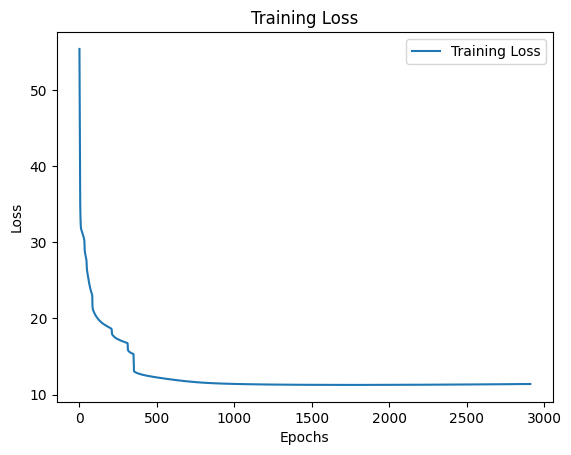

In [91]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


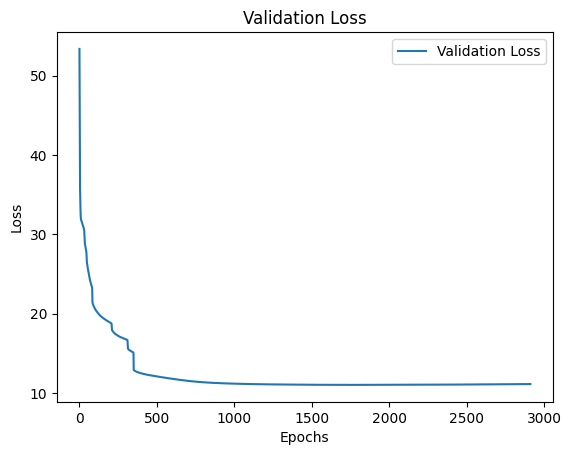

In [92]:
# Plot the training and validation loss
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

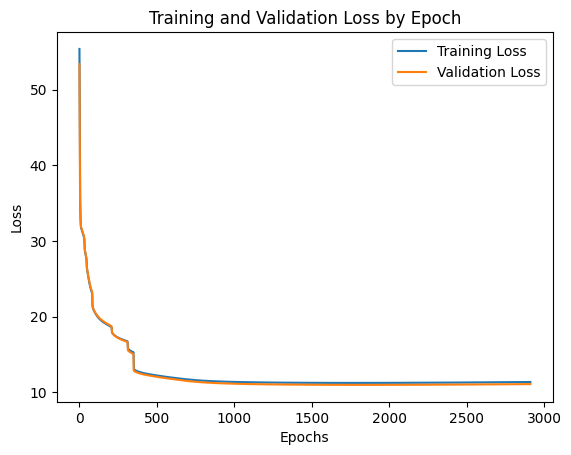

In [93]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()

In [94]:
# Use the trained autoencoder to reconstruct the validation set
X_val_reconstructed = autoencoder.predict(X_val)

# Calculate the mean squared reconstruction error
reconstruction_error = np.mean(np.square(X_val - X_val_reconstructed))
print(f'Average reconstruction error: {reconstruction_error}')


Average reconstruction error: 10.995898303454013


Text(0.5, 1.0, 'Pred')

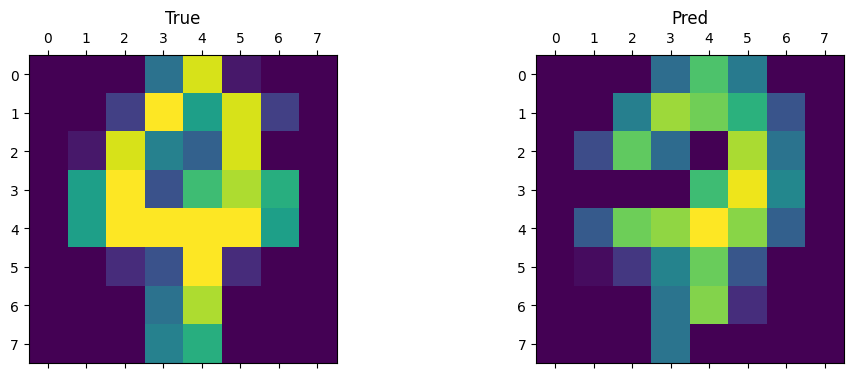

In [95]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].matshow(X_val[54].reshape((8, 8)))
ax[0].set_title("True")
ax[1].matshow(X_val_reconstructed[54].reshape((8, 8)))
ax[1].set_title("Pred")

The neural network is designed to train for 10000 epochs with an early stoping at 2911 epochs due to lack of improvement of the performance of the model after 1000 epochs (leniency) of training.

The learning rate of 0.00001 is chosen as any learning rate higher than this would cause large fluctuation in the validation and training loss.

Mean squared error is chosen in this case bacuase it is best used to measure the one-to-one loss of each pixel.

# Classifier

In [96]:
from nn import io
direct = "data/"
p_seqs = io.read_text_file(direct + 'rap1-lieb-positives.txt')
n_seqs = io.read_fasta_file(direct + 'yeast-upstream-1k-negative.fa')


In [97]:
window_size = len(p_seqs[0])
processed_negatives = []

step = 50
for seq in n_seqs:
    for i in range(0, len(seq) - window_size + 1, step * window_size):
        processed_negatives.append(seq[i:i + window_size])


In [98]:
from nn import preprocess
balanced_seqs, balanced_labels = preprocess.sample_seqs(p_seqs + processed_negatives, [True] * len(p_seqs) + [False] * len(processed_negatives))
encoded_seqs = preprocess.one_hot_encode_seqs(balanced_seqs)


- Chose a sampling scheme to address class imbalance in the dataset.
- Ensured equal representation of positive and negative classes for training.
- Balanced the dataset by selecting sequences with replacement to match the count of the more prevalent class, reducing bias towards the majority class.
- For negative sequences longer than positive ones, sliced them into smaller sequences of the same size as positive ones using a defined window size and step before sampling.
- Created a more equitable and diverse training set, promoting better model generalization.

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoded_seqs, balanced_labels, test_size=0.2, random_state=1729)
print("Training data size: ", X_train.shape[0])
print("Validation data size: ", X_val.shape[0])

Training data size:  10113
Validation data size:  2529


In [100]:
# Define the architechture of the classifier
nn_arch = [{'input_dim': len(X_train[0]), 'output_dim': 64, 'activation': 'relu'},
           {'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
           {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}]

NN = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.01, seed=492357816, batch_size=128, epochs=1000, 
                      loss_function='binary_cross_entropy', leniency = 100, progress = 100)


In [101]:
train_loss, val_loss = NN.fit(X_train, np.array([[i] for i in y_train]), X_val, np.array([[i] for i in y_val]))

Finished epoch 1 of 1000.
Finished epoch 101 of 1000.
Finished epoch 201 of 1000.
Early stopping triggered after 284 epochs.


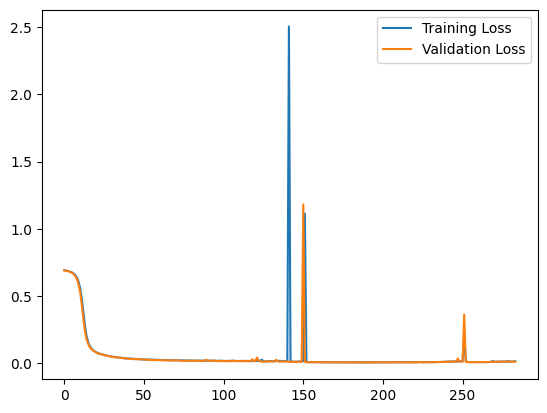

In [102]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()


In [103]:
pred = (NN.predict(X_val) >= 0.5).astype(int).T[0]
print(f"Final accuracy on validation set: {np.sum(pred == y_val) / len(y_val)}")

Final accuracy on validation set: 0.9988137603795967



- Chose binary cross entropy as the loss function for binary classification.

- Trained for 1000 epochs with early stopping after 100 epochs (leniency) for sufficient accuracy on the validation dataset.

- Selected a learning rate of 0.01 for relatively low loss and reasonable convergence time.

- Selected a batch size of 128 for suffient size for training but not an over-representing portion of the training data.